In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install Pillow
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/labels
os.chdir('data-science-bowl/kerasUnet')
!git checkout new-keras-unet

In [0]:
os.chdir('../../')
!rm -rf data-science-bowl/
!git clone https://github.com/bkahn-github/data-science-bowl.git
os.chdir('data-science-bowl/kerasUnet')
!git checkout new-keras-unet

In [2]:
import random

import PIL
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook

from load_data import load_data, load_test_data, load_test_image_sizes
from metrics import dice_loss, iou
from model import model
from process_data import threshold_preds, encode, upsample
from submit import submit

seed = 42
random.seed = seed
np.random.seed(seed=seed)

%matplotlib inline

Using TensorFlow backend.


In [3]:
x_train, y_train, x_val, y_val = load_data()

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 65/65 [00:00<00:00, 130.95it/s]


In [4]:
x_test = load_test_data()

  0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 65/65 [00:01<00:00, 51.24it/s]


In [5]:
x_test_sizes = load_test_image_sizes()

100%|██████████| 65/65 [00:00<00:00, 143.76it/s]


In [6]:
unet = model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
def get_train_augmented(x_train=x_train, y_train=y_train, batch_size=32, seed=seed):
  data_gen_args = dict(rotation_range=45., width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')


  x_datagen = ImageDataGenerator(**data_gen_args)
  y_datagen = ImageDataGenerator(**data_gen_args)
  x_datagen.fit(x_train, augment=True, seed=seed)
  y_datagen.fit(y_train, augment=True, seed=seed)
  x_train_augmented = x_datagen.flow(x_train, batch_size=batch_size, shuffle=True, seed=seed)
  y_train_augmented = y_datagen.flow(y_train, batch_size=batch_size, shuffle=True, seed=seed)

  train_generator = zip(x_train_augmented, y_train_augmented)
  return train_generator

In [8]:
batch_size = 8
train_generator = get_train_augmented(x_train, y_train, batch_size=batch_size)
unet.fit_generator(train_generator, validation_data=(x_val, y_val), steps_per_epoch=len(x_train)/(batch_size*2), epochs=50)

Epoch 1/50
34/33 [==============================] - 8s 235ms/step - loss: 0.5192 - keras_iou: 0.4366 - val_loss: 0.4245 - val_keras_iou: 0.4519
Epoch 2/50
34/33 [==============================] - 5s 157ms/step - loss: 0.4156 - keras_iou: 0.4499 - val_loss: 0.4138 - val_keras_iou: 0.4494
Epoch 3/50
34/33 [==============================] - 5s 159ms/step - loss: 0.4081 - keras_iou: 0.4491 - val_loss: 0.4160 - val_keras_iou: 0.4489
Epoch 4/50
34/33 [==============================] - 5s 159ms/step - loss: 0.4012 - keras_iou: 0.4488 - val_loss: 0.4110 - val_keras_iou: 0.4489
Epoch 5/50
34/33 [==============================] - 5s 157ms/step - loss: 0.4087 - keras_iou: 0.4484 - val_loss: 0.4076 - val_keras_iou: 0.4486
Epoch 6/50
34/33 [==============================] - 5s 157ms/step - loss: 0.3947 - keras_iou: 0.4484 - val_loss: 0.4069 - val_keras_iou: 0.4486
Epoch 7/50
 7/33 [=====>........................] - ETA: 3s - loss: 0.3688 - keras_iou: 0.4483

34/33 [==============================] - 5s 156ms/step - loss: 0.4032 - keras_iou: 0.4484 - val_loss: 0.4096 - val_keras_iou: 0.4484
Epoch 8/50
34/33 [==============================] - 5s 155ms/step - loss: 0.3841 - keras_iou: 0.4482 - val_loss: 0.3896 - val_keras_iou: 0.4484
Epoch 9/50
34/33 [==============================] - 5s 155ms/step - loss: 0.3813 - keras_iou: 0.4483 - val_loss: 0.3536 - val_keras_iou: 0.4481
Epoch 10/50
34/33 [==============================] - 5s 154ms/step - loss: 0.2769 - keras_iou: 0.4487 - val_loss: 0.2827 - val_keras_iou: 0.4519
Epoch 11/50
34/33 [==============================] - 5s 155ms/step - loss: 0.2479 - keras_iou: 0.4537 - val_loss: 0.2076 - val_keras_iou: 0.4581
Epoch 12/50
34/33 [==============================] - 5s 156ms/step - loss: 0.2022 - keras_iou: 0.4651 - val_loss: 0.1801 - val_keras_iou: 0.4749
Epoch 13/50
10/33 [=======>......................] - ETA: 3s - loss: 0.1769 - keras_iou: 0.4808

34/33 [==============================] - 5s 156ms/step - loss: 0.1778 - keras_iou: 0.4837 - val_loss: 0.1754 - val_keras_iou: 0.4886
Epoch 14/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1690 - keras_iou: 0.4947 - val_loss: 0.1652 - val_keras_iou: 0.5012
Epoch 15/50
34/33 [==============================] - 5s 158ms/step - loss: 0.1563 - keras_iou: 0.5073 - val_loss: 0.1726 - val_keras_iou: 0.5128
Epoch 16/50
34/33 [==============================] - 5s 154ms/step - loss: 0.1650 - keras_iou: 0.5193 - val_loss: 0.1770 - val_keras_iou: 0.5260
Epoch 17/50
34/33 [==============================] - 5s 158ms/step - loss: 0.1538 - keras_iou: 0.5315 - val_loss: 0.1449 - val_keras_iou: 0.5358
Epoch 18/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1470 - keras_iou: 0.5405 - val_loss: 0.1375 - val_keras_iou: 0.5462
Epoch 19/50
10/33 [=======>......................] - ETA: 3s - loss: 0.1220 - keras_iou: 0.5496

34/33 [==============================] - 5s 159ms/step - loss: 0.1424 - keras_iou: 0.5514 - val_loss: 0.1313 - val_keras_iou: 0.5551
Epoch 20/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1177 - keras_iou: 0.5602 - val_loss: 0.1326 - val_keras_iou: 0.5645
Epoch 21/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1320 - keras_iou: 0.5690 - val_loss: 0.1218 - val_keras_iou: 0.5727
Epoch 22/50
34/33 [==============================] - 5s 158ms/step - loss: 0.1277 - keras_iou: 0.5768 - val_loss: 0.1227 - val_keras_iou: 0.5805
Epoch 23/50
34/33 [==============================] - 5s 160ms/step - loss: 0.1184 - keras_iou: 0.5846 - val_loss: 0.1189 - val_keras_iou: 0.5878
Epoch 24/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1215 - keras_iou: 0.5916 - val_loss: 0.1155 - val_keras_iou: 0.5953
Epoch 25/50
10/33 [=======>......................] - ETA: 3s - loss: 0.1224 - keras_iou: 0.5972

34/33 [==============================] - 5s 156ms/step - loss: 0.1269 - keras_iou: 0.5983 - val_loss: 0.1216 - val_keras_iou: 0.6007
Epoch 26/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1232 - keras_iou: 0.6035 - val_loss: 0.1192 - val_keras_iou: 0.6069
Epoch 27/50
34/33 [==============================] - 5s 155ms/step - loss: 0.1151 - keras_iou: 0.6102 - val_loss: 0.1151 - val_keras_iou: 0.6127
Epoch 28/50
34/33 [==============================] - 5s 159ms/step - loss: 0.1152 - keras_iou: 0.6158 - val_loss: 0.1249 - val_keras_iou: 0.6181
Epoch 29/50
34/33 [==============================] - 5s 155ms/step - loss: 0.1100 - keras_iou: 0.6202 - val_loss: 0.1181 - val_keras_iou: 0.6226
Epoch 30/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1334 - keras_iou: 0.6247 - val_loss: 0.1108 - val_keras_iou: 0.6271
Epoch 31/50
10/33 [=======>......................] - ETA: 3s - loss: 0.1175 - keras_iou: 0.6285

34/33 [==============================] - 5s 159ms/step - loss: 0.1095 - keras_iou: 0.6296 - val_loss: 0.1036 - val_keras_iou: 0.6321
Epoch 32/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1108 - keras_iou: 0.6344 - val_loss: 0.1070 - val_keras_iou: 0.6364
Epoch 33/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1152 - keras_iou: 0.6382 - val_loss: 0.1049 - val_keras_iou: 0.6400
Epoch 34/50
34/33 [==============================] - 5s 158ms/step - loss: 0.1092 - keras_iou: 0.6424 - val_loss: 0.1060 - val_keras_iou: 0.6444
Epoch 35/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1058 - keras_iou: 0.6460 - val_loss: 0.1024 - val_keras_iou: 0.6480
Epoch 36/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1117 - keras_iou: 0.6500 - val_loss: 0.1106 - val_keras_iou: 0.6519
Epoch 37/50
10/33 [=======>......................] - ETA: 3s - loss: 0.0949 - keras_iou: 0.6527

34/33 [==============================] - 5s 156ms/step - loss: 0.1057 - keras_iou: 0.6536 - val_loss: 0.1021 - val_keras_iou: 0.6554
Epoch 38/50
34/33 [==============================] - 5s 159ms/step - loss: 0.1043 - keras_iou: 0.6571 - val_loss: 0.1225 - val_keras_iou: 0.6581
Epoch 39/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1078 - keras_iou: 0.6590 - val_loss: 0.1011 - val_keras_iou: 0.6605
Epoch 40/50
34/33 [==============================] - 5s 159ms/step - loss: 0.1046 - keras_iou: 0.6622 - val_loss: 0.1004 - val_keras_iou: 0.6638
Epoch 41/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1094 - keras_iou: 0.6655 - val_loss: 0.0997 - val_keras_iou: 0.6669
Epoch 42/50
34/33 [==============================] - 5s 159ms/step - loss: 0.1043 - keras_iou: 0.6682 - val_loss: 0.1106 - val_keras_iou: 0.6698
Epoch 43/50
10/33 [=======>......................] - ETA: 2s - loss: 0.1184 - keras_iou: 0.6708

34/33 [==============================] - 5s 154ms/step - loss: 0.1098 - keras_iou: 0.6714 - val_loss: 0.1001 - val_keras_iou: 0.6725
Epoch 44/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1016 - keras_iou: 0.6738 - val_loss: 0.0953 - val_keras_iou: 0.6753
Epoch 45/50
34/33 [==============================] - 5s 157ms/step - loss: 0.0983 - keras_iou: 0.6767 - val_loss: 0.0958 - val_keras_iou: 0.6778
Epoch 46/50
34/33 [==============================] - 5s 156ms/step - loss: 0.0976 - keras_iou: 0.6791 - val_loss: 0.1037 - val_keras_iou: 0.6804
Epoch 47/50
34/33 [==============================] - 5s 157ms/step - loss: 0.1035 - keras_iou: 0.6816 - val_loss: 0.1006 - val_keras_iou: 0.6826
Epoch 48/50
34/33 [==============================] - 5s 156ms/step - loss: 0.1113 - keras_iou: 0.6836 - val_loss: 0.0998 - val_keras_iou: 0.6847
Epoch 49/50
10/33 [=======>......................] - ETA: 3s - loss: 0.1065 - keras_iou: 0.6854

34/33 [==============================] - 5s 157ms/step - loss: 0.1030 - keras_iou: 0.6859 - val_loss: 0.1036 - val_keras_iou: 0.6866
Epoch 50/50
34/33 [==============================] - 5s 155ms/step - loss: 0.1029 - keras_iou: 0.6875 - val_loss: 0.0972 - val_keras_iou: 0.6884


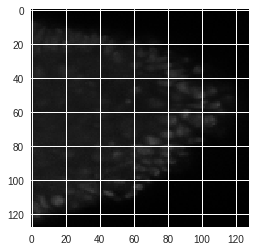

In [9]:
img = x_test[0]
plt.imshow(img.reshape(128, 128, 3))

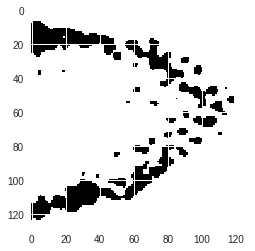

In [10]:
temp = unet.predict(img.reshape(1, 128, 128, 3))
plt.imshow((temp > 0.5).reshape(128, 128))

In [0]:
preds = unet.predict(x_test)

In [0]:
preds = threshold_preds(preds)

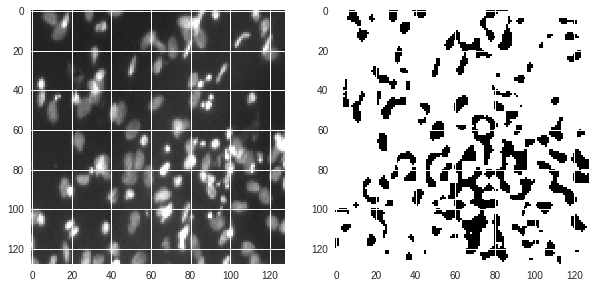

In [13]:
i=13
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(x_test[i])

plt.subplot(1, 2, 2)
plt.imshow(preds[i].reshape(128, 128))

In [0]:
preds_upsampled = upsample(preds, x_test_sizes)

In [0]:
test_path = '../../.kaggle/competitions/data-science-bowl-2018/test/'
test_ids = next(os.walk(test_path))[1]

rles, new_test_ids = encode(preds_upsampled, test_ids)

In [0]:
submit(new_test_ids, rles)

In [0]:
pd.read_csv('./submission.csv')

In [0]:
from google.colab import files

files.download('submission.csv')